In [15]:
import os,sys,string,re,gc,time
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
from unidecode import unidecode
from multiprocessing import Pool
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline
os.chdir('/data/arpit.goel/31_PricePrediction/03.Submissions')

In [22]:
%%time
NUM_BRANDS = 4004
NUM_CATEGORIES = 1001
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 30000
MAX_FEATURES_CATEGORY_NAME=1001
NUM_CORES = 24
NUM_PARTITIONS = 24

def get_cat_lookup(cats):
    cats=cats.value_counts().index.to_series()
    cats=pd.DataFrame(list(zip(*cats.str.split('/'))),columns=cats.index,index=['cat0','cat1','cat2']).T
    return cats

def clean_brand(brands):
    brands_map=brands.value_counts().index.to_series().map(lambda x: re.sub('[^0-9a-z]','',x.lower()))
    brands=brands.map(brands_map).value_counts().head(NUM_BRANDS).index.to_series()
    return brands_map.map(brands).fillna('missing')

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, NUM_PARTITIONS)
    pool = Pool(NUM_CORES)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return (df)

def get_features(df1):
    df=df1.copy()
    for col in ['category_name','brand_name','item_description','name']:
        df[col]=df[col].fillna(value='missing')
    return df

def to_categorical(df):
    for col in ['category_name','brand_name','item_condition_id','cat0','cat1','cat2']:
        df[col]=df[col].astype('category')

if 1==1:
    start_time = time.time()
    train = pd.read_table('../input/train.tsv', engine='c',index_col=['train_id'])
    test = pd.read_table('../input/test.tsv', engine='c',index_col=['test_id'])
    print('[{}] Finished to load data'.format(time.time() - start_time))
    print('Train shape: ', train.shape)
    print('Test shape: ', test.shape)
    train['source']=np.where(np.random.random(train.shape[0])<0.8,'train','valid')
    train=train[train['price']>0]
    train['log_price']=np.log1p(train['price'])
    test['source']='test'
    master=pd.concat([train,test])
    del train,test
    gc.collect()

    cat_lookup=get_cat_lookup(master['category_name'])
    brand_lookup=clean_brand(master['brand_name'])
    master=pd.merge(master,cat_lookup,left_on=['category_name'],right_index=True,how='left')
    master['brand_name']=master['brand_name'].map(brand_lookup)
    master=parallelize_dataframe(master,get_features)
    to_categorical(master)

[7.766151666641235] Finished to load data
Train shape:  (1482535, 7)
Test shape:  (693359, 6)
CPU times: user 20.1 s, sys: 4.17 s, total: 24.3 s
Wall time: 24.6 s


In [23]:
if 1==1:
#     cv = CountVectorizer(min_df=NAME_MIN_DF)
#     X_name = cv.fit_transform(master['name'])
#     print('[{}] Finished count vectorize `name`'.format(time.time() - start_time))

#     cv = CountVectorizer(max_features=MAX_FEATURES_CATEGORY_NAME)
#     X_category = cv.fit_transform(master['category_name'])
#     print('[{}] Finished count vectorize `category_name`'.format(time.time() - start_time))

    tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION,ngram_range=(1, 3),stop_words='english')
    tv.fit(master[master['source']=='train']['item_description'])
    X_description = tv.transform(master['item_description'])
    print('[{}] Finished TFIDF vectorize `item_description`'.format(time.time() - start_time))

    lb = LabelBinarizer(sparse_output=True)
    X_brand = lb.fit_transform(master['brand_name'])
    print('[{}] Finished label binarize `brand_name`'.format(time.time() - start_time))

    X_dummies = csr_matrix(pd.get_dummies(master[['item_condition_id', 'shipping','cat0','cat1','cat2']],sparse=True).values)
    print('[{}] Finished to get dummies on `item_condition_id` and `shipping`'.format(time.time() - start_time))

    sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()
    print('[{}] Finished to create sparse merge'.format(time.time() - start_time))



[241.81066870689392] Finished TFIDF vectorize `item_description`
[258.857381105423] Finished label binarize `brand_name`
[330.63500332832336] Finished to get dummies on `item_condition_id` and `shipping`
[372.3767876625061] Finished to create sparse merge


In [55]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb

NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000
NUM_CORES = 4
NUM_PARTITIONS = 24

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, NUM_PARTITIONS)
    pool = Pool(NUM_CORES)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return (df)

def get_features(df1):
    df=df1.copy()
    for col in ['general_cat','subcat_1','subcat_2','brand_name','item_description']:
        df[col].fillna(value='missing', inplace=True)
    return df

def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    for col in ['general_cat','subcat_1','subcat_2']:
        pop_category1 = dataset[col].value_counts().index[:NUM_CATEGORIES]
        dataset.loc[~dataset[col].isin(pop_category1), col] = 'missing'

def to_categorical(dataset):
    for col in ['general_cat','subcat_1','subcat_2','item_condition_id']:
        dataset[col]=dataset[col].astype('category')

def main():
    start_time = time.time()
    train = pd.read_table('../input/train.tsv', engine='c',index_col=['train_id'])
    test = pd.read_table('../input/test.tsv', engine='c',index_col=['test_id'])
    train['source']=np.where(np.random.random(len(train))<0.8,'train','valid')
    test['source']='test'
    train['log_price']=np.log1p(train['price'])
    print('[{}] Finished to load data'.format(time.time() - start_time))
    print('Train shape: ', train.shape)
    print('Test shape: ', test.shape)
    
    master=pd.concat([train, test]).sort_values(by='source').reset_index()
    data_indices=master['source'].value_counts().sort_index()
    del train,test
    gc.collect()

    master['general_cat'],master['subcat_1'],master['subcat_2']=zip(*master['category_name'].str.split('/'))
    master.drop('category_name', axis=1, inplace=True)
    print('[{}] Split categories completed.'.format(time.time() - start_time))
    
    cutting(merge)
    print('[{}] Cut completed.'.format(time.time() - start_time))
    
    master=parallelize_dataframe(master,get_features)
    print('[{}] Featured Created.'.format(time.time() - start_time))

    to_categorical(merge)
    print('[{}] Convert categorical completed'.format(time.time() - start_time))

    cv = CountVectorizer(min_df=NAME_MIN_DF)
    X_name = cv.fit_transform(merge['name'])
    print('[{}] Count vectorize `name` completed.'.format(time.time() - start_time))

    cv = CountVectorizer()
    X_category=cv.fit_transform(merge['general_cat','subcat_1','subcat_2','brand_name'].apply(lambda x: ' '.join(x.to_series()),axis=1))
    print('[{}] Count vectorize `categories` completed.'.format(time.time() - start_time))

    tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION,
                         ngram_range=(1, 3),
                         stop_words='english')
    tv.fit(merge['item_description'][merge['source']=='train'])
    X_description=tv.transform(merge['item_description'])
    print('[{}] TFIDF vectorize `item_description` completed.'.format(time.time() - start_time))

    X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']],
                                          sparse=True).values)
    print('[{}] Get dummies on `item_condition_id` and `shipping` completed.'.format(time.time() - start_time))

    sparse_merge = hstack((X_dummies, X_description, X_brand, X_category1, X_category2, X_category3, X_name)).tocsr()
    print('[{}] Create sparse merge completed'.format(time.time() - start_time))

    X = sparse_merge[:nrow_train]
    X_test = sparse_merge[nrow_train:]
    
    model = Ridge(alpha=.05, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, random_state=101, solver='auto', tol=0.001)
    model.fit(X, y)
    print('[{}] Train ridge completed'.format(time.time() - start_time))
    predsR = model.predict(X=X_test)
    print('[{}] Predict ridge completed'.format(time.time() - start_time))

    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.15, random_state = 144) 
    d_train = lgb.Dataset(train_X, label=train_y)
    d_valid = lgb.Dataset(valid_X, label=valid_y)
    watchlist = [d_train, d_valid]
    
    params = {
        'learning_rate': 0.5,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 60,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 1,
        'bagging_fraction': 0.5,
        'nthread': 4
    }

    params2 = {
        'learning_rate': 1,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 140,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 2,
        'bagging_fraction': 1,
        'nthread': 4
    }

    model = lgb.train(params, train_set=d_train, num_boost_round=8000, valid_sets=watchlist, \
    early_stopping_rounds=250, verbose_eval=1000) 
    predsL = model.predict(X_test)
    
    print('[{}] Predict lgb 1 completed.'.format(time.time() - start_time))
    
    train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X, y, test_size = 0.1, random_state = 101) 
    d_train2 = lgb.Dataset(train_X2, label=train_y2)
    d_valid2 = lgb.Dataset(valid_X2, label=valid_y2)
    watchlist2 = [d_train2, d_valid2]

    model = lgb.train(params2, train_set=d_train2, num_boost_round=8000, valid_sets=watchlist2, \
    early_stopping_rounds=250, verbose_eval=1000) 
    predsL2 = model.predict(X_test)

    print('[{}] Predict lgb 2 completed.'.format(time.time() - start_time))

    preds = predsR*0.35 + predsL*0.35 + predsL2*0.3

    submission['price'] = np.expm1(preds)
    submission.to_csv("submission_ridge_2xlgbm.csv", index=False)

if __name__ == '__main__':
    main()
    

[8.170339822769165] Finished to load data
Train shape:  (1482535, 8)
Test shape:  (693359, 7)
[22.77139949798584] Split categories completed.
[23.641415119171143] Handle missing completed.
[27.097188711166382] Cut completed.
[29.451393365859985] Convert categorical completed
[51.94930028915405] Count vectorize `name` completed.
[96.00221490859985] Count vectorize `categories` completed.
[405.68449330329895] TFIDF vectorize `item_description` completed.
[426.8408203125] Label binarize `brand_name` completed.
[434.8984463214874] Get dummies on `item_condition_id` and `shipping` completed.
[479.1367869377136] Create sparse merge completed


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[643.8545405864716] Train ridge completed
[643.9303398132324] Predict ridge completed


In [90]:
    start_time = time.time()
    train = pd.read_table('../input/train.tsv', engine='c',index_col=['train_id'])
    test = pd.read_table('../input/test.tsv', engine='c',index_col=['test_id'])
    train['source']=np.where(np.random.random(len(train))<0.8,'train','valid')
    test['source']='test'
    train['log_price']=np.log1p(train['price'])
    print('[{}] Finished to load data'.format(time.time() - start_time))
    print('Train shape: ', train.shape)
    print('Test shape: ', test.shape)
    
    master=pd.concat([train, test]).sort_values(by='source').reset_index()
    data_indices=master['source'].value_counts().sort_index()

[8.302959442138672] Finished to load data
Train shape:  (1482535, 9)
Test shape:  (693359, 7)


In [106]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDRegressor

NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000
NUM_CORES = 4
NUM_PARTITIONS = 24

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, NUM_PARTITIONS)
    pool = Pool(NUM_CORES)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return (df)

def get_features(df1):
    df=df1.copy()
    for col in ['general_cat','subcat_1','subcat_2','brand_name','item_description']:
        df[col].fillna(value='missing', inplace=True)
    return df

def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    for col in ['general_cat','subcat_1','subcat_2']:
        pop_category1 = dataset[col].value_counts().index[:NUM_CATEGORIES]
        dataset.loc[~dataset[col].isin(pop_category1), col] = 'missing'

def to_categorical(dataset):
    for col in ['general_cat','subcat_1','subcat_2','item_condition_id']:
        dataset[col]=dataset[col].astype('category')

if 1==1:
    start_time = time.time()
    train = pd.read_table('../input/train.tsv', engine='c',index_col=['train_id'])
    test = pd.read_table('../input/test.tsv', engine='c',index_col=['test_id'])
    train=train[train['price']>0]
    train['source']=np.where(np.random.random(len(train))<0.8,'train','valid')
    test['source']='test'
    train['log_price']=np.log1p(train['price'])
    print('[{}] Finished to load data'.format(time.time() - start_time))
    print('Train shape: ', train.shape)
    print('Test shape: ', test.shape)
    
    master=pd.concat([train, test]).sort_values(by='source').reset_index()
    data_indices=master['source'].value_counts().sort_index()
    del train,test
    gc.collect()

    master['general_cat'],master['subcat_1'],master['subcat_2']=zip(*master['category_name'].fillna('//').str.split('/'))
    master.drop('category_name', axis=1, inplace=True)
    print('[{}] Split categories completed.'.format(time.time() - start_time))
    
    cutting(master)
    print('[{}] Cut completed.'.format(time.time() - start_time))
    
    master=parallelize_dataframe(master,get_features)
    print('[{}] Featured Created.'.format(time.time() - start_time))

    to_categorical(master)
    print('[{}] Convert categorical completed'.format(time.time() - start_time))

    cv = CountVectorizer(min_df=NAME_MIN_DF)
    X_name = cv.fit_transform(master['name'])
    print('[{}] Count vectorize `name` completed.'.format(time.time() - start_time))

    cv = CountVectorizer()
    X_category=cv.fit_transform(master[['general_cat','subcat_1','subcat_2','brand_name']].apply(lambda x: ' '.join(x),axis=1))
    print('[{}] Count vectorize `categories` completed.'.format(time.time() - start_time))

    tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION,
                         ngram_range=(1, 3),
                         stop_words='english')
    tv.fit(master['item_description'][master['source']=='train'])
    X_description=tv.transform(master['item_description'])
    print('[{}] TFIDF vectorize `item_description` completed.'.format(time.time() - start_time))

    X_dummies = csr_matrix(pd.get_dummies(master[['item_condition_id', 'shipping']],
                                          sparse=True).values)
    print('[{}] Get dummies on `item_condition_id` and `shipping` completed.'.format(time.time() - start_time))

    sparse_merge = hstack((X_dummies, X_description, X_category, X_name)).tocsr()
    print('[{}] Create sparse merge completed'.format(time.time() - start_time))

    X_train=sparse_merge[data_indices[0]:data_indices[0]+data_indices[1]]
    X_valid=sparse_merge[data_indices[0]+data_indices[1]:]
    X_test=sparse_merge[:data_indices[0]]
    Y_train=master[master['source']=='train']['log_price']
    Y_valid=master[master['source']=='valid']['log_price']
  
    model = Ridge(alpha=.05, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, random_state=101, solver='auto', tol=0.001)
    model.fit(X_train, Y_train)

    print (mean_squared_error(Y_train,model.predict(X_train)))
    print (mean_squared_error(Y_valid,model.predict(X_valid)))
   
    test=master[master['source']=='test']['index'].to_frame('test_id')
    test['price']=np.expm1(model.predict(X_test))
    test.to_csv('Submission.csv', index=False)

[234.19634532928467] Count vectorize `categories` completed.
[592.9020230770111] TFIDF vectorize `item_description` completed.
[600.9767420291901] Get dummies on `item_condition_id` and `shipping` completed.


In [122]:
    model = Ridge(alpha=.05, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, random_state=101, solver='auto', tol=0.001)
    model.fit(X_train, Y_train)


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, random_state=101, solver='auto', tol=0.001)

In [127]:
    test=master[master['source']=='test']['index'].to_frame('test_id')
    test['price']=np.expm1(model.predict(X_test))
    test.to_csv('Submission.csv', index=False)

In [116]:
print (X_train.shape,X_valid.shape,X_test.shape)

(1186413, 76328) (296122, 76328) (693359, 76328)


In [125]:
master.head()

,index,brand_name,item_condition_id,item_description,log_price,name,price,shipping,source,general_cat,subcat_1,subcat_2
0,693358,missing,2,2 Floral scrub tops. Worn less than 5 times ea...,NaN,"FREESHIP 2 Floral Scrub Tops, medium.",NaN,1,test,Women,Tops & Blouses,T-Shirts
1,231121,missing,1,FRESHLOOK COLORED BLENDS CONTAC LENSES -FREE C...,NaN,FREE SHP BLUE CONTAC LENSES,NaN,1,test,Beauty,Makeup,Eyes
2,231120,INC International Concepts,4,Black sandals,NaN,Inc,NaN,0,test,Women,Shoes,Sandals
3,231119,missing,1,Brand new,NaN,Cooling headband,NaN,0,test,Women,Women's Accessories,Hair Accessories
4,231118,missing,2,Item Used In great condition! Please no low of...,NaN,Sweater size xs! Final price,NaN,0,test,Women,Sweaters,Crewneck


In [110]:
data_indices[0]

693359

In [50]:
for data in [X_category, X_name]:
    X_train=data[master.index[master['source']=='valid'].to_series(),:]
    X_valid=data[master.index[master['source']=='train'].to_series(),:]
    print (X_train.shape,X_valid.shape)

    model = Ridge(solver="sag", fit_intercept=True, random_state=205)
    model.fit(X_train, master[master['source']=='valid']['log_price'])

    print (np.sqrt(mean_squared_error(master[master['source']=='valid']['log_price'],model.predict(X_train))))
    print (np.sqrt(mean_squared_error(master[master['source']=='train']['log_price'],model.predict(X_valid))))


(1186461, 1001) (295200, 1001)
0.745469523727
0.747061465701


IndexError: invalid index

In [33]:
X_dummies[[1,3,4],:5].todense()

matrix([[0, 0, 0, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [39]:
master.index[master['source']=='valid'].to_series()

0                0
1                1
2                2
3                3
4                4
5                5
6                6
7                7
8                8
10              10
11              11
12              12
13              13
14              14
15              15
16              16
17              17
18              18
19              19
20              20
21              21
23              23
25              25
26              26
27              27
28              28
29              29
30              30
32              32
33              33
            ...   
1482502    1482502
1482503    1482503
1482505    1482505
1482506    1482506
1482507    1482507
1482508    1482508
1482509    1482509
1482510    1482510
1482511    1482511
1482512    1482512
1482513    1482513
1482514    1482514
1482515    1482515
1482516    1482516
1482518    1482518
1482519    1482519
1482520    1482520
1482521    1482521
1482522    1482522
1482523    1482523
1482524    1482524
1482525    1

In [ ]:
    X = sparse_merge[:nrow_train]
    X_test = sparse_merge[nrow_train:]
    
    d_train = lgb.Dataset(X, label=y)
    
    params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

    model = lgb.train(params, train_set=d_train, num_boost_round=3200, verbose_eval=100) 
    preds = 0.57*model.predict(X_test)

    model = Ridge(solver="sag", fit_intercept=True, random_state=205)
    model.fit(X, y)
    print('[{}] Finished to train ridge'.format(time.time() - start_time))
    preds += 0.43*model.predict(X=X_test)
    print('[{}] Finished to predict ridge'.format(time.time() - start_time))


    submission['price'] = np.expm1(preds)
    submission.to_csv("submission_lgbm_ridge_5.csv", index=False)

    
    

In [77]:
if 1==1:
    to_space= '''&,()+'"/'''
    trans=str.maketrans(to_space, ' '*len(to_space)) #Change to str when submitting
    ps = PorterStemmer()

    os.chdir('/data/arpit.goel/31_PricePrediction/03.Submissions')  #Remove while sumbitting
    pd.set_option('display.float_format', lambda x: '%.1f' % x)

    df_raw_train=pd.read_csv('../input/train.tsv',delimiter='\t')
    df_raw_test=pd.read_csv('../input/test.tsv',delimiter='\t')
    df_raw_train['log_price']=np.log1p(df_raw_train['price'])
    df_raw_train['source']='train'
    df_raw_test['source']='test'
    master=pd.concat([df_raw_train,df_raw_test])
    master['id']=master['train_id'].fillna(master['test_id'])
    master.drop(labels=['train_id','test_id'],axis=1)

In [253]:
    train = pd.read_table('../input/train.tsv', engine='c',index_col=['train_id'])
    test = pd.read_table('../input/test.tsv', engine='c',index_col=['test_id'])


In [257]:
pd.concat([train,test]).tail()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping
693354,NaN,Home/Home Décor/Home Décor Accents,1,Flint/Quartz cluster. Self mined ✨measures 3x2...,Quartz crystal on Flint stone,nan,0
693355,IT Cosmetics,Beauty/Makeup/Makeup Sets,1,It Cosmetics travel bundle. Includes: Brow pow...,It Cosmetics - Travel Bundle,nan,1
693356,NaN,"Electronics/Cell Phones & Accessories/Cases, C...",1,New. Free shipping Basstop case,Galaxy S8 hard shell case,nan,1
693357,NaN,Women/Swimwear/Cover-Ups,2,Floral kimono. Tropical print. Open front. Hi ...,Hi low floral kimono,nan,0
693358,NaN,Women/Tops & Blouses/T-Shirts,2,2 Floral scrub tops. Worn less than 5 times ea...,"FREESHIP 2 Floral Scrub Tops, medium.",nan,1


In [78]:
from sklearn.preprocessing import LabelEncoder
cats=master['category_name'].value_counts().index.to_series()
cats=pd.DataFrame(list(zip(*cats.str.split('/'))),columns=cats.index,index=['Cat0','Cat1','Cat2']).T
for cat in ['Cat0','Cat1','Cat2']:
    cats[cat]=cats[cat].map(unidecode)
    
for cat in ['Cat0','Cat1','Cat2']:
    master['cat_feat_%s'%cat]=master['category_name'].map(cats[cat]).astype('category').cat.codes
for col in ['brand_name','item_condition_id','shipping']:
    master['cat_feat_%s'%col]=master[col].astype('category').cat.codes

In [84]:
master.head()

,brand_name,category_name,item_condition_id,item_description,log_price,name,price,shipping,source,test_id,train_id,id,cat_feat_Cat0,cat_feat_Cat1,cat_feat_Cat2,cat_feat_brand_name,cat_feat_item_condition_id,cat_feat_shipping
0,NaN,Men/Tops/T-shirts,3,No description yet,2.4,MLB Cincinnati Reds T Shirt Size XL,10.0,1,train,nan,0.0,0.0,5,101,773,-1,2,1
1,Razer,Electronics/Computers & Tablets/Components & P...,3,This keyboard is in great condition and works ...,4.0,Razer BlackWidow Chroma Keyboard,52.0,0,train,nan,1.0,1.0,1,30,215,3889,2,0
2,Target,Women/Tops & Blouses/Blouse,1,Adorable top with a hint of lace and a key hol...,2.4,AVA-VIV Blouse,10.0,1,train,nan,2.0,2.0,9,102,97,4588,0,1
3,NaN,Home/Home Décor/Home Décor Accents,1,New with tags. Leather horses. Retail for [rm]...,3.6,Leather Horse Statues,35.0,1,train,nan,3.0,3.0,3,54,410,-1,0,1
4,NaN,Women/Jewelry/Necklaces,1,Complete with certificate of authenticity,3.8,24K GOLD plated rose,44.0,0,train,nan,4.0,4.0,9,57,542,-1,0,0


In [90]:
import nltk
text = nltk.word_tokenize("Adorable top with a beautiful hint of ugly lace and ")
a=nltk.pos_tag(text)


In [98]:
a1,a2=zip(*a)
pd.Series(Counter(a2))

CC    1
DT    1
IN    2
JJ    2
NN    3
RB    1
dtype: int64

In [118]:
%%time

def get_pos_tagging(text):
    text = nltk.word_tokenize(text)
    a1,a2=zip(*nltk.pos_tag(text))
    return pd.Series(Counter(a2))

def get_free_text_vars(df,var,label):
    df['ft_0_%s'%label]=df[var].astype(np.str).str.len()                                                             # Num characters
    df['ft_1_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[%s]'%string.printable,'',x)).str.len()         # Num non printable chars
    df['ft_2_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^#$%&*:;<=>?@\^_`|~]','',x)).str.len()         # Num Special Characters
    df['ft_3_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^0-9]','',x)).str.len()                        # Num numerals
    df['ft_4_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^a-z]','',x)).str.len()                        # Num lower case
    df['ft_5_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^A-Z]','',x)).str.len()                        # Num upper case
    df['ft_6_%s'%label]=df[var].astype(np.str).map(lambda x: re.sub('[^ ]','',x)).str.len()                          # Num spaces
    df['%s_clean'%label]=df[var].astype(np.str).str.lower().map(lambda x: re.sub('[^ a-z]',' ',x))                   # Clean Text
    df2=df[var].apply(get_pos_tagging)
    df2.columns=['%s_%s'%(label,x) for x in df2.columns]
    return pd.concat([df,df2],axis=1)
    return df

master1=get_free_text_vars(master,'name','name')
master1=get_free_text_vars(master1,'item_description','item_description')

KeyboardInterrupt: 

In [158]:
os.chdir('/data/arpit.goel/31_PricePrediction/03.Submissions') 
store={}
for file in ['master']:
    store[file]=pd.read_hdf('../01.RawData/master.h5', file)
store['master']['log_price']=np.log1p(store['master']['price'])

In [172]:
for pos in vocab1: 
    store['master']['pos_name_%s'%pos]=store['master']['name_pos'].str.count(pos)
    store['master']['pos_desc_%s'%pos]=store['master']['item_description_pos'].str.count(pos)

KeyboardInterrupt: 

In [155]:
for col in [x for x in store['master'].columns if x[:3]=='pos'][:2]:
    print (store['master'].groupby([col])['log_price'].agg({np.size,np.mean}))

             mean  size
pos_name_CC            
0             3.0  99.0
1             2.7   1.0
             mean  size
pos_desc_CC            
0             2.9  45.0
1             2.9  31.0
2             3.2  13.0
3             3.4   5.0
4             2.8   4.0
5             4.0   2.0


In [164]:
vocab=set([y for x in store['master']['item_description_pos'].str.split(' ') for y in x])
vocab=vocab.union(set([y for x in store['master']['name_pos'].str.split(' ') for y in x]))

In [171]:
vocab1=[re.sub('[^A-Z]','',x) for x in list(vocab)]
vocab1=[x for x in vocab1 if len(x)>0]
len(vocab1)

36

In [173]:
store['master']['name_pos'].head()

0    NNP NNP NNP NNP NNP NNP NNP
1                NNP NNP NNP NNP
2                    NNP NNP NNP
3                    NNP NNP NNP
4                 CD NNP VBD VBD
Name: name_pos, dtype: object

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


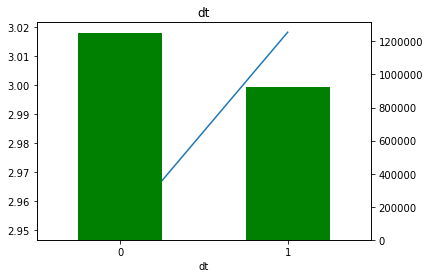

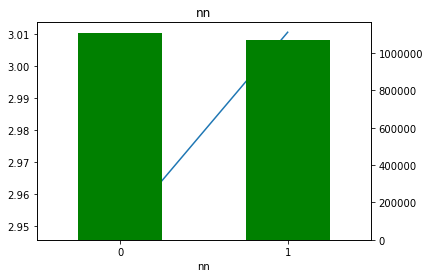

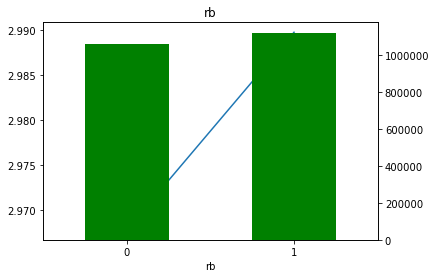

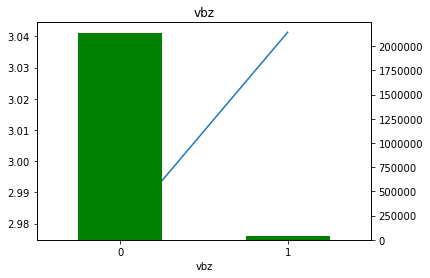

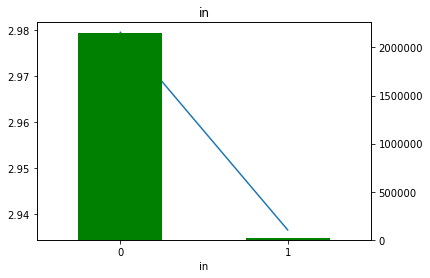

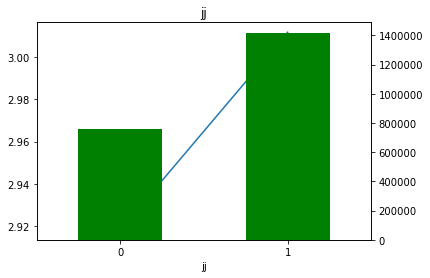

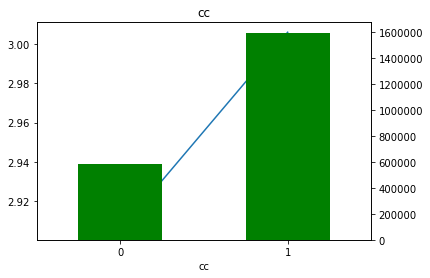

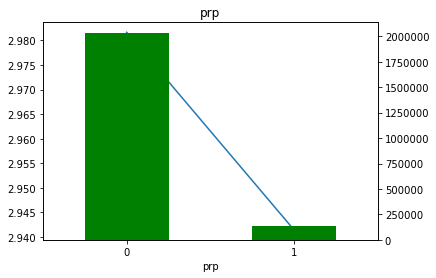

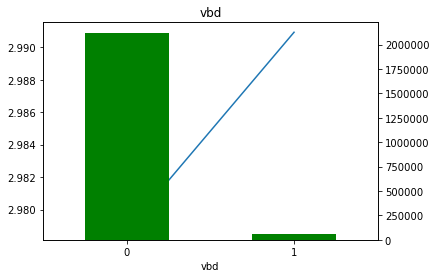

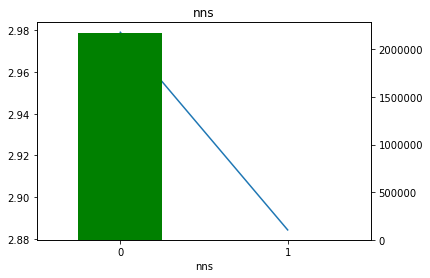

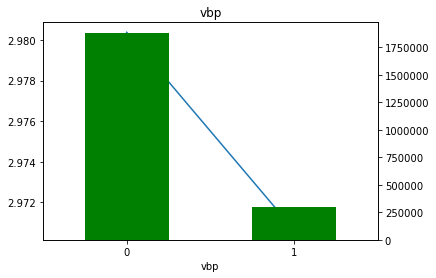

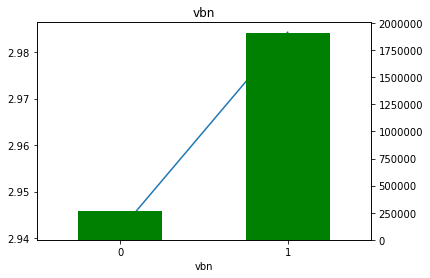

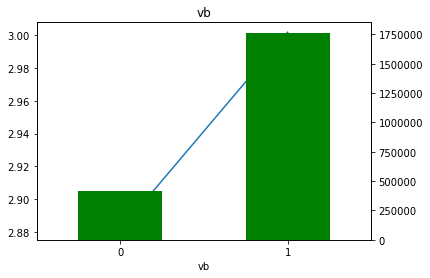

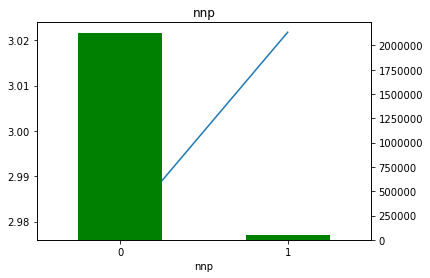

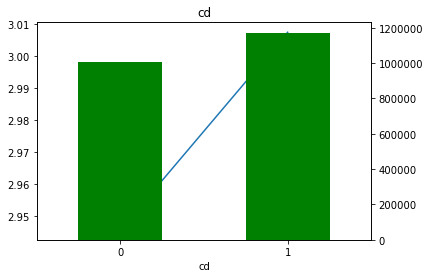

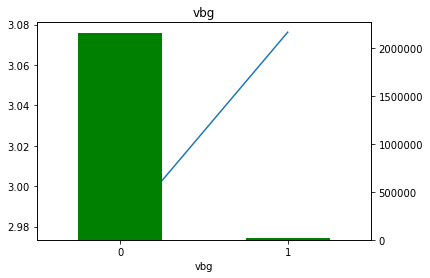

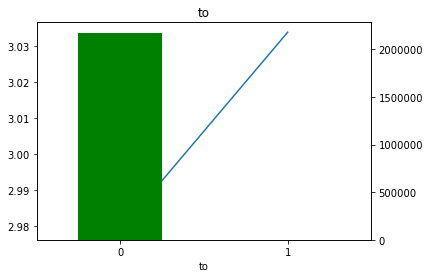

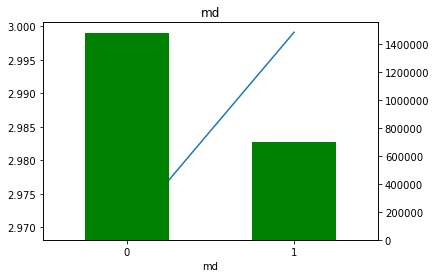

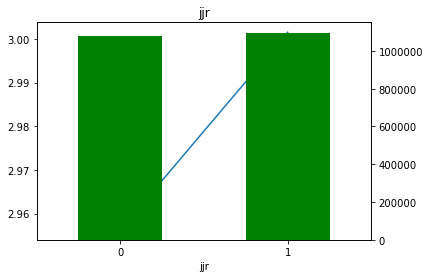

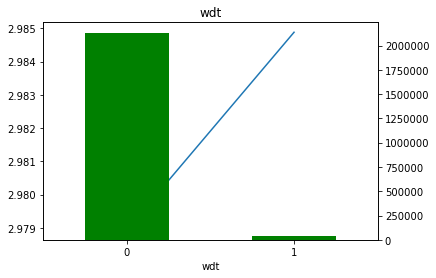

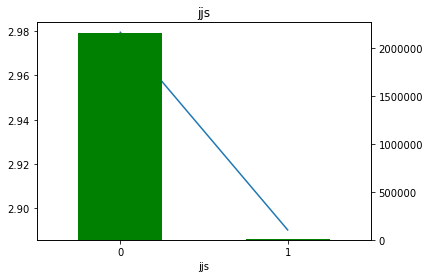

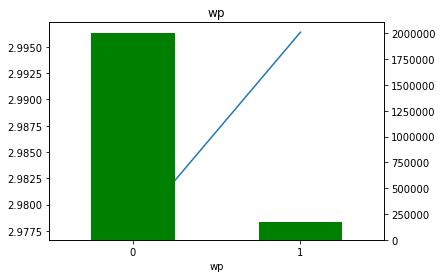

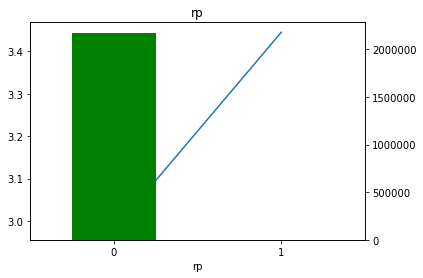

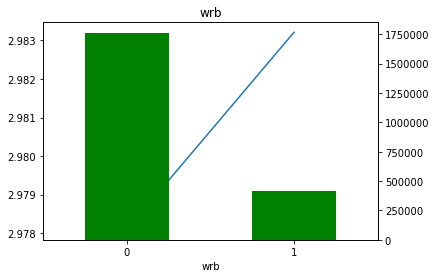

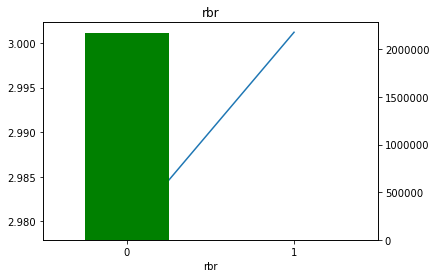

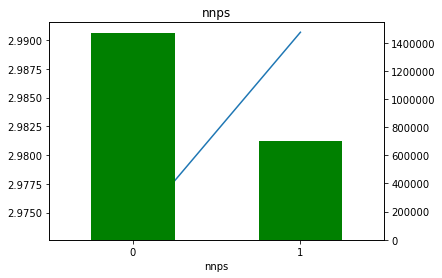

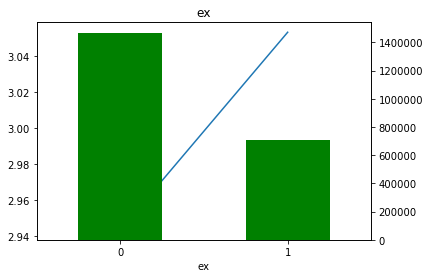

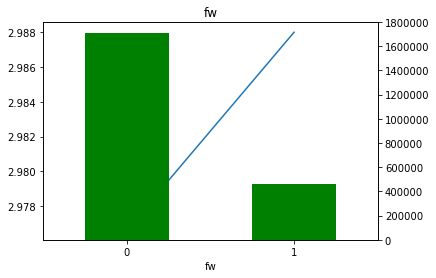

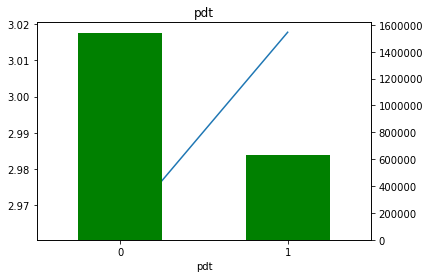

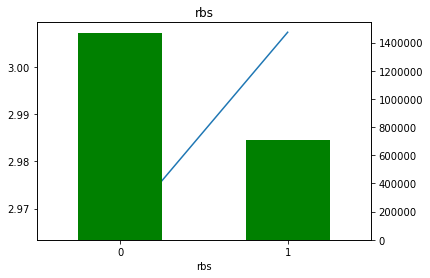

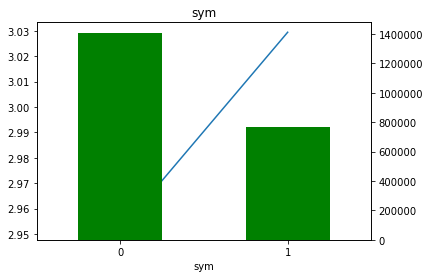

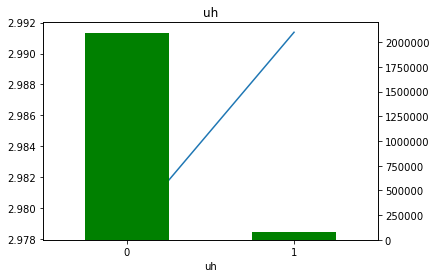

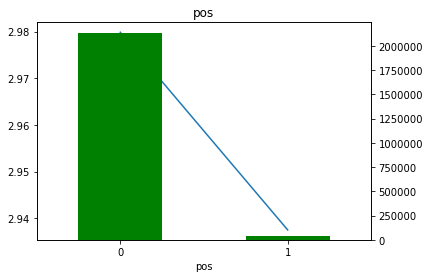

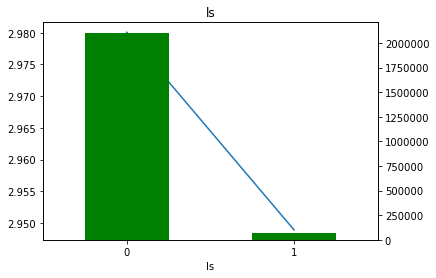

In [249]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(binary=True)
name=cv.fit_transform(store['master']['item_description_pos'])
name=pd.DataFrame(name.todense(),columns=list(cv.vocabulary_.keys()))
plt.figure()
for i,col in enumerate(list(cv.vocabulary_.keys())):
    a=store['master'].groupby(name[col])['log_price'].agg({np.size,np.mean})
    fig, ax1 = plt.subplots()
    a['mean'].plot()
    ax2 = ax1.twinx()
    a['size'].plot(kind='bar',color='g')
    plt.title(col)

ValueError: Shape of passed values is (35, 2869253), indices imply (35, 2175894)

In [247]:
store['master'][['log_price']].shape

(2175894, 1)

In [203]:
name=pd.DataFrame(name.todense(),columns=list(cv.vocabulary_.keys())).sum(axis=1)

0          7
1          4
2          3
3          3
4          4
5          5
6          5
7          7
8          4
9          6
10         2
11         6
12         3
13         3
14         5
15         4
16         2
17         7
18         5
19         5
20         5
21         6
22         5
23         3
24         5
25         4
26         7
27         7
28         4
29         2
          ..
2175864    6
2175865    6
2175866    5
2175867    6
2175868    3
2175869    5
2175870    3
2175871    5
2175872    7
2175873    2
2175874    3
2175875    6
2175876    3
2175877    5
2175878    5
2175879    5
2175880    3
2175881    4
2175882    5
2175883    3
2175884    3
2175885    7
2175886    7
2175887    5
2175888    4
2175889    5
2175890    4
2175891    5
2175892    4
2175893    6
dtype: int64

In [193]:
%%time
NUM_BRANDS = 4004
NUM_CATEGORIES = 1001
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 3000
MAX_FEATURES_CATEGORY_NAME=1001
NUM_CORES = 4
NUM_PARTITIONS = 24

def get_cat_lookup(cats):
    cats=cats.value_counts().index.to_series()
    cats=pd.DataFrame(list(zip(*cats.str.split('/'))),columns=cats.index,index=['cat0','cat1','cat2']).T
    return cats

def clean_brand(brands):
    brands_map=brands.value_counts().index.to_series().map(lambda x: re.sub('[^0-9a-z]','',x.lower()))
    brands=brands.map(brands_map).value_counts().head(NUM_BRANDS).index.to_series()
    return brands_map.map(brands).fillna('missing')

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, NUM_PARTITIONS)
    pool = Pool(NUM_CORES)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return (df)

def get_features(df1):
    df=df1.copy()
    for col in ['category_name','brand_name','item_description','name']:
        df[col]=df[col].fillna(value='missing')
    return df

def to_categorical(df):
    for col in ['category_name','brand_name','item_condition_id']:
        df[col]=df[col].astype('category')

if 1==1:
    start_time = time.time()
    train = pd.read_table('../input/train.tsv', engine='c',index_col=['train_id'])
    test = pd.read_table('../input/test.tsv', engine='c',index_col=['test_id'])
    print('[{}] Finished to load data'.format(time.time() - start_time))
    print('Train shape: ', train.shape)
    print('Test shape: ', test.shape)
    train['source']='train'
    test['source']='test'
    master=pd.concat([train,test])
    nrow_train = train.shape[0]
    y = np.log1p(train["price"])
    
    del train,test
    gc.collect()

    cat_lookup=get_cat_lookup(master['category_name'])
    brand_lookup=clean_brand(master['brand_name'])
    master=pd.merge(master,cat_lookup,left_on=['category_name'],right_index=True,how='left')
    master['brand_name']=master['brand_name'].map(brand_lookup)
    master=parallelize_dataframe(master,get_features)
    to_categorical(master)

    cv = CountVectorizer(min_df=NAME_MIN_DF)
    X_name = cv.fit_transform(master['name'])
    print('[{}] Finished count vectorize `name`'.format(time.time() - start_time))

    cv = CountVectorizer(max_features=MAX_FEATURES_CATEGORY_NAME)
    X_category = cv.fit_transform(master['category_name'])
    print('[{}] Finished count vectorize `category_name`'.format(time.time() - start_time))

    tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION,ngram_range=(1, 3),stop_words='english')
    X_description = tv.fit_transform(master['item_description'])
    print('[{}] Finished TFIDF vectorize `item_description`'.format(time.time() - start_time))

    lb = LabelBinarizer(sparse_output=True)
    X_brand = lb.fit_transform(master['brand_name'])
    X_cat0 = lb.fit_transform(master['cat0'])
    X_cat1 = lb.fit_transform(master['cat1'])
    X_cat2 = lb.fit_transform(master['cat2'])
    print('[{}] Finished label binarize `brand_name`'.format(time.time() - start_time))

    X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']],sparse=True).values)
    print('[{}] Finished to get dummies on `item_condition_id` and `shipping`'.format(time.time() - start_time))

    sparse_merge = hstack((X_dummies, X_description, X_brand,X_cat0,X_cat1,X_cat2, X_category, X_name)).tocsr()
    print('[{}] Finished to create sparse merge'.format(time.time() - start_time))

    X = sparse_merge[:nrow_train]
    X_test = sparse_merge[nrow_train:]
    
    d_train = lgb.Dataset(X, label=y)
    
    params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

    model = lgb.train(params, train_set=d_train, num_boost_round=3200, verbose_eval=100) 
    preds = 0.57*model.predict(X_test)

    model = Ridge(solver="sag", fit_intercept=True, random_state=205)
    model.fit(X, y)
    print('[{}] Finished to train ridge'.format(time.time() - start_time))
    preds += 0.43*model.predict(X=X_test)
    print('[{}] Finished to predict ridge'.format(time.time() - start_time))


    submission['price'] = np.expm1(preds)
    submission.to_csv("submission_lgbm_ridge_5.csv", index=False)

    
    

{'cc',
 'cd',
 'dt',
 'ex',
 'fw',
 'in',
 'jj',
 'jjr',
 'jjs',
 'ls',
 'md',
 'nn',
 'nnp',
 'nnps',
 'nns',
 'pdt',
 'pos',
 'prp',
 'rb',
 'rbr',
 'rbs',
 'rp',
 'sym',
 'to',
 'uh',
 'vb',
 'vbd',
 'vbg',
 'vbn',
 'vbp',
 'vbz',
 'wdt',
 'wp',
 'wrb'}